<a href="https://colab.research.google.com/github/Vamshi-Nallaguntla/Diabetes_Detection_Using_CNN/blob/main/70-30_Split.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install keras-tuner --upgrade
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Lambda, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
import keras_tuner as kt
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [ ]:
# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
df = pd.read_csv(url, names=columns)

In [ ]:
# Separate features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into 70/30
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [ ]:
# Define SAE for data augmentation
def build_sae(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim * 2, activation="relu")(input_layer)
    encoded = Dense(encoding_dim, activation="relu")(encoded)
    decoded = Dense(encoding_dim * 2, activation="relu")(encoded)
    decoded = Dense(input_dim, activation="sigmoid")(decoded)
    sae = Model(input_layer, decoded)
    sae.compile(optimizer='adam', loss='mse')
    return sae

# Train SAE
sae = build_sae(input_dim=X_train.shape[1], encoding_dim=4)
sae.fit(X_train, X_train, epochs=300, batch_size=32, shuffle=True, validation_split=0.1)

# Generate synthetic data with SAE
encoded_data = sae.predict(X_train)
synthetic_data_sae = encoded_data + np.random.normal(0, 0.01, encoded_data.shape)

Epoch 1/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 1.2711 - val_loss: 1.2122
Epoch 2/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2276 - val_loss: 1.2005
Epoch 3/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2281 - val_loss: 1.1887
Epoch 4/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1928 - val_loss: 1.1749
Epoch 5/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1789 - val_loss: 1.1585
Epoch 6/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1124 - val_loss: 1.1395
Epoch 7/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1624 - val_loss: 1.1179
Epoch 8/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1174 - val_loss: 1.0947
Epoch 9/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0316 - val_loss: 1.0712
Epoch 10/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0551 - val_loss: 1.0485
Epoch 11/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9994 - val_loss: 1.0260
Epoch 12/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

In [ ]:
# Define VAE for data augmentation
latent_dim = 4
input_layer = Input(shape=(X_train.shape[1],))
h = Dense(8, activation="relu")(input_layer)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
decoder_input = Input(shape=(latent_dim,))
decoder_h = Dense(8, activation="relu")(decoder_input)
decoder_mean = Dense(X_train.shape[1], activation="sigmoid")(decoder_h)
decoder = Model(decoder_input, decoder_mean)

vae_output = decoder(z)
vae = Model(input_layer, vae_output)
vae.compile(optimizer='adam', loss='mse')
vae.fit(X_train, X_train, epochs=300, batch_size=32, validation_split=0.1, verbose=0)

# Generate synthetic data with VAE
latent_samples = np.random.normal(size=(len(X_train), latent_dim))
synthetic_data_vae = decoder.predict(latent_samples)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [ ]:
# Combine original and synthetic data
X_augmented = np.vstack((X_train, synthetic_data_sae, synthetic_data_vae))
y_augmented = np.hstack((y_train, np.random.choice(y_train, len(synthetic_data_sae) + len(synthetic_data_vae))))

# Balance classes with SMOTE
smote = SMOTE()
X_augmented, y_augmented = smote.fit_resample(X_augmented, y_augmented)

# Reshape for CNN input
X_augmented_reshaped = X_augmented[..., np.newaxis]
X_test_reshaped = X_test[..., np.newaxis]

In [ ]:
# Define the CNN model
def build_cnn_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_augmented_reshaped.shape[1], 1)))
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(Conv1D(
            filters=hp.Choice(f'filters_{i}', [32, 64, 128]),
            kernel_size=hp.Choice(f'kernel_size_{i}', [2, 3]),
            activation=hp.Choice('activation', ['relu', 'tanh', 'elu']),
            padding='same'
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Flatten())
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(Dense(
            units=hp.Choice(f'units_{i}', [32, 64, 128, 256, 512]),
            activation=hp.Choice('dense_activation', ['relu', 'tanh', 'elu'])
        ))
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Hyperparameter tuning
tuner = kt.RandomSearch(
    build_cnn_model,
    objective='val_accuracy',
    max_trials=100,
    directory='tuner_results',
    project_name='cnn_tuning'
)

In [ ]:
# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

# Custom callback for testing metrics
class TestMetricsCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_accuracies = []
        self.test_losses = []

    def on_epoch_end(self, epoch, logs=None):
        X_test, y_test = self.test_data
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        self.test_losses.append(test_loss)
        self.test_accuracies.append(test_accuracy)
        print(f"Epoch {epoch+1} - Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

# Perform hyperparameter tuning
tuner.search(X_augmented_reshaped, y_augmented, epochs=300, validation_split=0.1, callbacks=[lr_scheduler, early_stopping])

# Train the final model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
final_model = tuner.hypermodel.build(best_hps)

test_metrics_callback = TestMetricsCallback(test_data=(X_test_reshaped, y_test))
history = final_model.fit(
    X_augmented_reshaped, y_augmented,
    epochs=300,
    batch_size=32,
    callbacks=[test_metrics_callback],
    verbose=1
)

# Display the best hyperparameters
print("Best Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

Trial 100 Complete [00h 00m 20s]
val_accuracy: 0.9571428298950195

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 30m 06s
Epoch 1/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5507 - loss: 0.6921Epoch 1 - Test Accuracy: 0.5325, Test Loss: 0.6868
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5507 - loss: 0.6921
Epoch 2/300
35/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5690 - loss: 0.6506 Epoch 2 - Test Accuracy: 0.6450, Test Loss: 0.6412
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5737 - loss: 0.6483
Epoch 3/300
35/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5942 - loss: 0.6472 Epoch 3 - Test Accuracy: 0.6970, Test Loss: 0.5945
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5889 - loss: 0.6463
Epoch 4/300
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5837 - loss: 0.6464Epoch 4 - Test Accuracy: 0.6883, Test Loss: 0.5764
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5840 - loss: 0.6463
Epoch 5/300
35/66 ━━━━━━━━━━━━━━━━━

In [ ]:
# Display the best hyperparameters
print("Best Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

Best Hyperparameters:
num_conv_layers: 1
filters_0: 32
kernel_size_0: 2
activation: tanh
num_dense_layers: 2
units_0: 128
dense_activation: elu
dropout: 0.1
optimizer: rmsprop
filters_1: 64
kernel_size_1: 3
filters_2: 64
kernel_size_2: 3
units_1: 32
units_2: 64


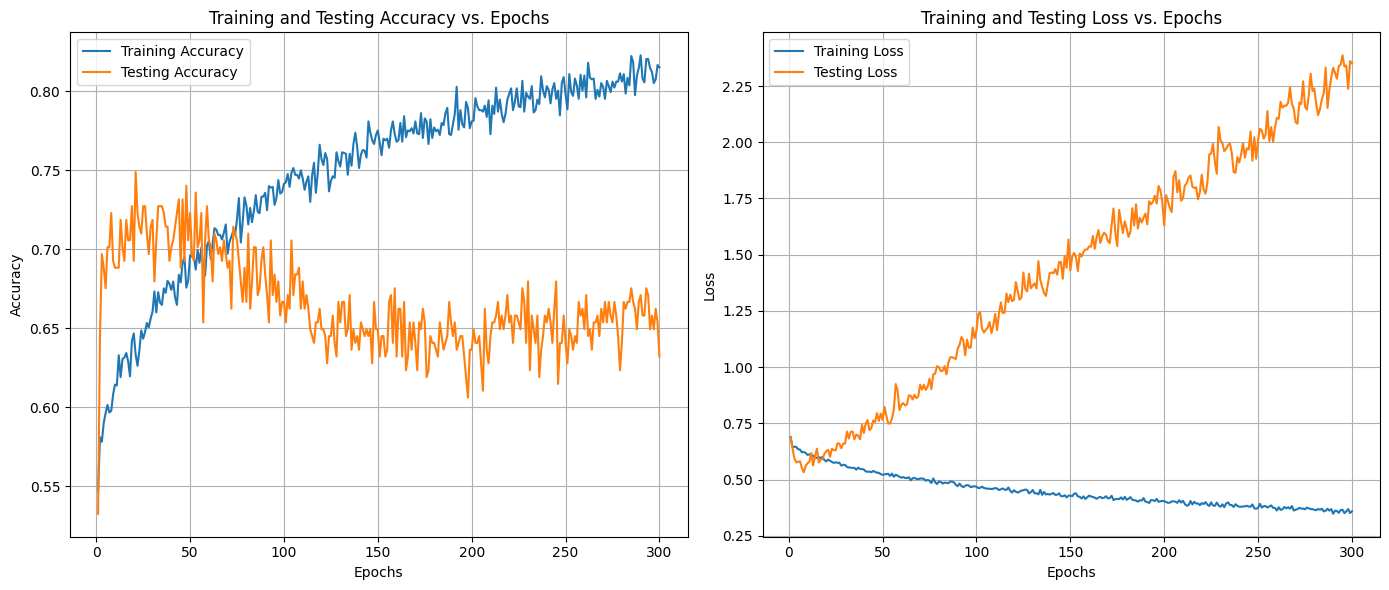

In [ ]:
# Plot training and testing metrics
epochs = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, test_metrics_callback.test_accuracies, label='Testing Accuracy')
plt.title('Training and Testing Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, test_metrics_callback.test_losses, label='Testing Loss')
plt.title('Training and Testing Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate Final Model
y_pred = (final_model.predict(X_test_reshaped) > 0.5).astype(int)
metrics = {
    'accuracy': accuracy_score(y_test, y_pred) * 100,
    'precision': precision_score(y_test, y_pred) * 100,
    'recall': recall_score(y_test, y_pred) * 100,
    'f1_score': f1_score(y_test, y_pred) * 100,
    'auc': roc_auc_score(y_test, final_model.predict(X_test_reshaped).flatten()) * 100
}

print("\nTest Set Metrics (in percentages):")
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Test Set Metrics (in percentages):
Accuracy: 63.20%
Precision: 47.13%
Recall: 51.25%
F1_score: 49.10%
Auc: 70.40%
